HHU Deep Learning, SS2024, 12.02.2024, Prof. Dr. Markus Kollmann

Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 01 - Representation Learning with AutoEncoders

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise and submitted code for each task, you will receive 1 point for this assignment, regardless of the quality of your solution.

If you cannot proceed past some part you need to ask on RocketChat ahead of the deadline.


## <center> DUE FRIDAY 19.04.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/IfZBP5wfAhjPxRw](https://uni-duesseldorf.sciebo.de/s/IfZBP5wfAhjPxRw)

---



## Introduction to Autoencoders

An autoencoder (AE) is a neural network that learns to reconstruct its input data by compressing the input into a lower-dimensional representation, which is called a **bottleneck** or latent representation. The basic architecture of an autoencoder consists of two main components: an encoder and a decoder. The encoder takes the input data and maps it to the bottleneck representation. The decoder then takes this bottleneck representation and maps it back to the original input space.

During training, the autoencoder tries to minimize the reconstruction loss between the original input and the reconstructed output. The weights of the encoder and decoder are adjusted during training to minimize this reconstruction error. By minimizing the reconstruction loss, the autoencoder learns to compress the input data into a lower-dimensional representation while preserving the essential information.


Autoencoders can be used for representation learning by leveraging the encoder as a feature extractor. The learned features can be more informative and discriminative than the original input data, especially when it has a high dimensionality. Autoencoders can also be used for transfer learning, where the pre-trained encoder can be fine-tuned on a new dataset for a different task.


The learned features can be used for downstream tasks such as classification, clustering, or regression.

In this exercise, we will focus on image classification. The bottleneck representation learned by the autoencoder will be used as a feature vector for a classifier.





# Part I. Basic imports


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
import random
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm.notebook import tqdm

# Getting the data


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([16, 3, 96, 96]) torch.Size([16])
torch.Size([16, 3, 96, 96]) torch.Size([16])


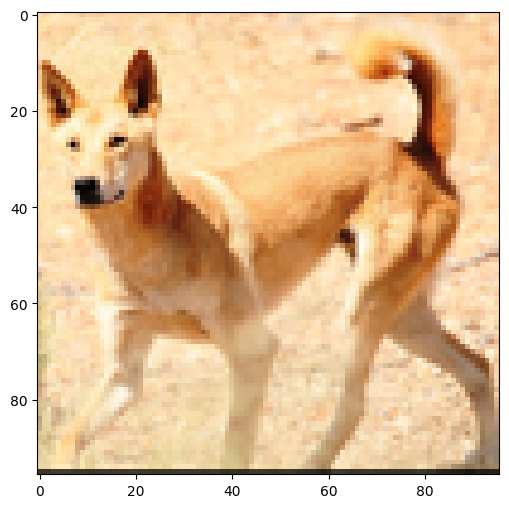

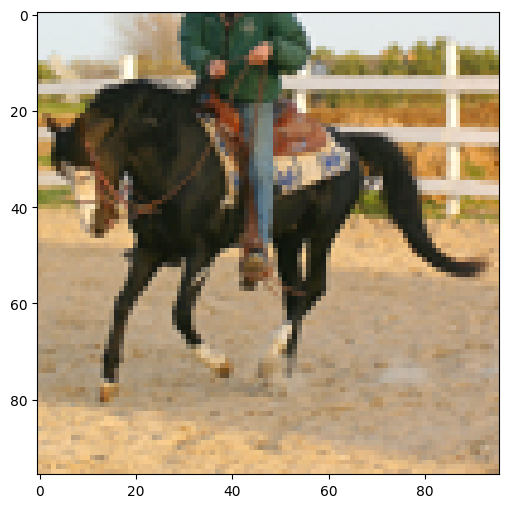

In [2]:

def load_data( batch_size=128, train_split="unlabeled", test_split="test"):
    # Returns a train and validation dataloader for STL10 dataset
    ### START CODE HERE ### (≈ 6 lines of code)
    transf = T.Compose([T.ToTensor()])
    train_ds = torchvision.datasets.STL10(root='../data', split=train_split, transform=transf, download=True)
    val_ds = torchvision.datasets.STL10(root='../data', split=test_split, transform=transf, download=True)
    n_loaders = os.cpu_count()
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_loaders, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=n_loaders, pin_memory=True)
    ### END CODE HERE ###
    return train_dl, val_dl

def imshow(img, i=0, mean=torch.tensor([0.0], dtype=torch.float32), std=torch.tensor([1], dtype=torch.float32)):
    """
    shows an image on the screen. mean of 0 and variance of 1 will show the images unchanged in the screen
    """
    # undoes the normalization
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def test_load_data():
    train_dl, val_dl = load_data(batch_size=16)
    for i, (x, y) in enumerate(train_dl):
        print(x.shape, y.shape)
        plt.figure(figsize=(6, 6))
        imshow(x[0,...])
        break
    for i, (x, y) in enumerate(val_dl):
        print(x.shape, y.shape)
        plt.figure(figsize=(6, 6))
        imshow(x[0,...])
        break

test_load_data()

# Build the AutoEncoder

- Given in_channels, base_channels, n_layers, kernel_size,stride,padding
- Build a symmetrical autoencoder with convolutions and transpose convolutions.
- For all the intermediate layers, use the ReLU function. Sigmoid for the output.
- Base channels are the out channels of the first conv layer in the encoder.
- Each subsequent encoder layer doubles the channels of the previous.
- Each subsequent decoder layer halves the channels of the previous.
- The implementation should support a varying number of layers (`n_layers`)
- The Conv and Transpose conv take the same kernel size, stride and padding.
- Choose kernel size and padding to halve the feature dimension in the encoder.

#### Hints:
You can use the `layers = nn.ModuleList()` to append the layers and then plug them in `nn.Sequential(*layers)`


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels, base_channels, n_layers, kernel_size, stride, padding):
        """Builds the autoencoder model

        Args:
            in_channels: number of input channels (3 for RGB images)
            base_channels: number of channels in the first conv layer of the encoder
            n_layers: number of conv/transp_conv layers in the encoder/decoder
            kernel_size: kernel size for the conv/transp_conv layers
            stride: stride for the conv/transp_conv layers
            padding: padding for the conv/transp_conv layers
        """
        super(Autoencoder, self).__init__()
        # Optional to use nn.ModuleList
        enc_layers = nn.ModuleList()
        dec_layers = nn.ModuleList()
        ### START CODE HERE ### (≈ 2 lines of code)
        self.base_channels = base_channels
        self.n_layers = n_layers
        act = nn.ReLU()
        start_channels = in_channels
        LAST = n_layers-1
        for i in range(n_layers):
            enc_layers.append(nn.Conv2d(start_channels, base_channels, kernel_size, stride=stride, padding=padding))
            enc_layers.append(act)
            # Do not double the dimensions in the last layer
            if i != LAST:
                start_channels = base_channels
                base_channels *= 2

        for i in range(n_layers):
            # Return to the original number of channels in the last layer
            if i == LAST:
                start_channels = in_channels
                act = nn.Sigmoid()
            dec_layers.append(nn.ConvTranspose2d(base_channels, start_channels, kernel_size, stride=stride, padding=padding))
            dec_layers.append(act)
            # halve the dimensions
            base_channels = base_channels//2
            start_channels = start_channels//2
        ### END CODE HERE ###
        self.encoder = nn.Sequential(*enc_layers)
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        return reconstruction

    ### START CODE HERE ###
    # Implement additional methods if needed
    def encode(self, x):
        return self.encoder(x)

    def get_bottleneck_dim(self):
        return self.base_channels*pow(2, self.n_layers-1)
    def get_flatten_dim(self, img_size=96):
        return self.base_channels*pow(2, self.n_layers-1)*img_size//pow(2,self.n_layers)*img_size//pow(2,self.n_layers)
    ### END CODE HERE ###

def test_Autoencoder():
    base_channels=4
    n_layers = 4
    autoencoder = Autoencoder(base_channels=base_channels, n_layers=n_layers,
                                in_channels=5, kernel_size=3, stride=2, padding=1)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
    x = torch.randn(1, 5, 32, 32).to(device)
    reconstruction = autoencoder(x)
    bottleneck = autoencoder.encode(x)
    assert bottleneck.shape == (1, 32 , 2, 2), "Bottleneck shape is not correct"
    print("Autoencoder test passed!")

test_Autoencoder()

Autoencoder test passed!


# Validate function


First, we will implement the validation function. We will use later it in the train function. The idea is to test our model on the (unseen) validation data in regular intervals during training, e.g. after every epoch (traversal of the whole dataset).

`Exercise`: Implement the validation function, which reads in data from the val_loader, runs a forward pass and records the loss. The validation loop typically follows these steps:
- Set the model to evaluation mode. This is important because it disables any dropout or batch normalization layers, which are used during training but not during inference.
- Iterate through the validation loader.
- For each batch, pass the input data through the model to get the predicted outputs.
- Compare the predicted outputs with the ground-truth labels to calculate a loss value.
- Aggregate the loss values across all batches to get a total validation loss.

In [4]:
def validate(model, val_loader,criterion, device):
    ### START CODE HERE ### (≈ 12 lines of code)
    model.eval()
    correct, total = 0, 0
    loss_step = []
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validating", leave=False):
            inp_data,labels = data
            inp_data = inp_data.to(device)
            outputs = model(inp_data)
            val_loss = criterion(outputs, inp_data)
            loss_step.append(val_loss.item())
        # dont forget to take the means here
        val_loss_epoch = np.mean(loss_step)
    ### END CODE HERE ###
        return val_loss_epoch

# Train one epoch function

The training loop typically follows these steps:
- Set the model to training mode.
- Iterate through the training dataset in batches.
- Forward propagation: For each batch, pass the input data through the model to get the predicted outputs.
- Backward propagation: Compute loss function:Calculate the loss value between the predicted outputs and the ground-truth labels using a loss function.
- Calculate the gradients of the loss with respect to the model parameters.
- Update parameters: Update the model parameters based on the gradients.

In [5]:
def train_one_epoch(model, optimizer, train_loader, criterion, device):
    ### START CODE HERE ### (≈ 12 lines of code)
    model.train()
    loss_step = []
    for data in tqdm(train_loader, leave=False, desc="Training"):
        # Move the data to the GPU
        inp_data,labels = data
        inp_data = inp_data.to(device)
        outputs = model(inp_data)
        loss = criterion(outputs, inp_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_step.append(loss.item())
    # dont forget the means here
    loss_curr_epoch = np.mean(loss_step)
    ### END CODE HERE ###
    return loss_curr_epoch

# Train code

Combine train_one_epoch and validation code into a single script.

A dictionary should be returned with the train and validation loss per epoch.

Save the model with the smallest validation loss

In [6]:
def save_model(model, path, epoch, optimizer, val_loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        }, path)

def train(model, optimizer, num_epochs, train_loader, val_loader, criterion, device):
    dict_log = {"train_loss":[], "val_loss":[]}
    ### START CODE HERE ### (≈ 12 lines of code)
    best_val_loss = 1e8
    best_val_acc = 0
    model = model.to(device)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch = train_one_epoch(model, optimizer, train_loader, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        # Print epoch results to screen
        msg = (f'Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}')
        pbar.set_description(msg)

        dict_log["train_loss"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)

        # Use this code to save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, f'best_model_min_val_loss.pth', epoch, optimizer, val_loss)
        ### END CODE HERE ###
    return dict_log

# Launch training!
Choose the model and hyperparameters and launch the training.
The training should not take more than 1h (26mins with our setup).

In [7]:
### START CODE HERE ###
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(base_channels=16,n_layers=4, in_channels=3, kernel_size=4, stride=2, padding=1)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.004)
train_dl, val_dl = load_data(batch_size=256)
dict_log = train(autoencoder, optimizer, 40, train_dl, val_dl, criterion, device)
### END CODE HERE ###

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

### Expected result
Val Loss $\sim 0.003$

# Loading the best model and visualizing reconstructions

Model best_model_min_val_loss.pth is loaded from epoch 35 , loss 0.0030829043753328733
Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


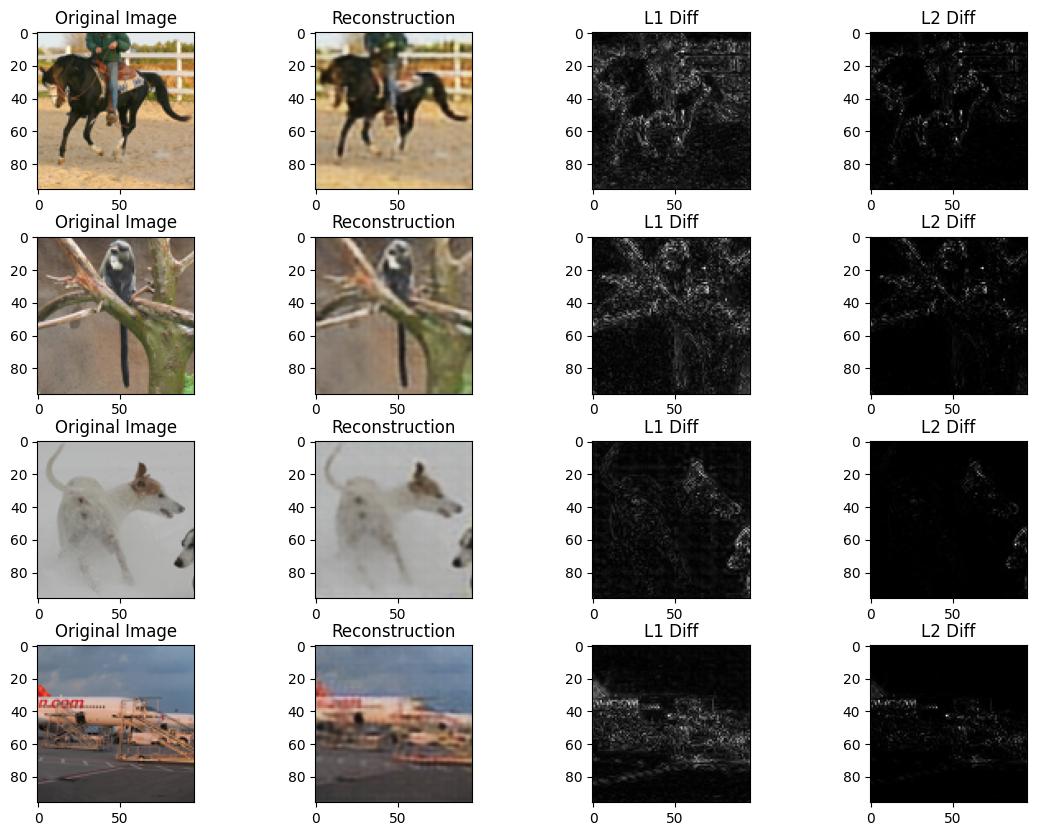

In [11]:
def load_model(model, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model {path} is loaded from epoch {checkpoint['epoch']} , loss {checkpoint['loss']}")
    return model

def get_reconstruction(autoencoder, img_batch):
    autoencoder.eval()
    autoencoder = autoencoder.to(device)
    img_batch = img_batch.to(device)
    reconstruction = autoencoder(img_batch)
    reconstruction = reconstruction.cpu().detach()
    return reconstruction

### START CODE HERE ### (≈ 8 line of code)
# Load the model with the best validation loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(base_channels=16, n_layers=4, in_channels=3, kernel_size=4, stride=2, padding=1)
autoencoder = load_model(autoencoder, "best_model_min_val_loss.pth")
# get a batch of validation images
_, val_dl = load_data(batch_size=4)
img_batch = next(iter(val_dl))[0]
# Get the reconstructions
reconstructions = get_reconstruction(autoencoder, img_batch)
# Calculate l1 and l2 differences between the original and reconstructed images
l1_diff = torch.sum(torch.abs(img_batch - reconstructions), axis=1)
l2_diff = torch.sum(torch.square(img_batch - reconstructions), axis=1)
### END CODE HERE ###


# Plotting code is provided for you
batch = img_batch.shape[0]
plt.figure(figsize=(14,10))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for i in range(batch):
    plt.subplot(batch,4, i*batch+1)
    plt.title(f"Original Image")
    imshow(img_batch[i,...])
    plt.subplot(batch,4, i*batch+2)
    imshow(reconstructions[i,...])
    plt.title(f"Reconstruction")
    plt.subplot(batch,4, i*batch+3)
    plt.imshow(l1_diff[i,...], cmap='gray')
    plt.title(f"L1 Diff")
    plt.subplot(batch,4, i*batch+4)
    plt.imshow(l2_diff[i,...], cmap='gray')
    plt.title(f"L2 Diff")
plt.savefig("viz_reconstructions.png")
plt.show()

 ### Expected result

![im1](https://github.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/raw/main/exercises/week01/figs/viz_reconstructions_solution.png)

# Get the features from the trained encoder

In [13]:
# Provided
def get_features(model, dataloader, device):
    model = model.to(device)
    feats, labs = [], []
    for i in dataloader:
        inp_data,labels = i
        inp_data = inp_data.to(device)
        features = model(inp_data)
        features = features.cpu().detach().flatten(start_dim=1)
        labels = labels.cpu().detach()
        feats.append(features)
        labs.append(labels)
    f = torch.cat(feats, dim=0)
    l = torch.cat(labs, dim=0)
    return f,l

### START CODE HERE ### (≈ 8 line of code)
autoencoder = Autoencoder(base_channels=16,n_layers=4, in_channels=3, kernel_size=4, stride=2, padding=1)
autoencoder = load_model(autoencoder, "best_model_min_val_loss.pth")
encoder = autoencoder.encoder
print()
train_dl, val_dl = load_data(batch_size=512, train_split="train")
train_feats, train_labels = get_features(encoder, train_dl, device)
val_feats, val_labels = get_features(encoder, val_dl, device)
torch.save(train_feats, "train_feats.pth")
torch.save(val_feats, "val_feats.pth")
torch.save(train_labels, "train_labels.pth")
torch.save(val_labels, "val_labels.pth")
### END CODE HERE ###

Model best_model_min_val_loss.pth is loaded from epoch 35 , loss 0.0030829043753328733

Files already downloaded and verified
Files already downloaded and verified


# Linear evaluation: Probing

Linear evaluation or probing is a technique used in deep learning to evaluate the quality of the learned representations in pre-trained neural networks. The basic idea is to train a linear classifier on top of a pre-trained network and use it to perform a downstream task that can be different from the pre-training objective.

The pre-trained network is usually trained on a large dataset with the aim of learning useful representations that can be reused for other tasks. By training a linear classifier on top of the pre-trained network, we can evaluate how well the learned representations capture the relevant information for the new task. If the pre-trained network has learned useful representations, we should be able to achieve good performance on the new task without having to train the entire network from scratch.

Below you have to used the saved features and train a liner classifier on top on the training split of STL10.


```python
def train_one_epoch(model, optimizer, train_loader, device)
def validate(model, val_loader, device)
def linear_eval(model, optimizer, num_epochs, train_loader, val_loader, device)
```

In [14]:
### START CODE HERE ### (>20 line of code)
def validate(model, val_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct, total = 0, 0
    loss_step = []
    with torch.no_grad():
        for data in val_loader:
            inp_data,labels = data
            inp_data = inp_data.to(device)
            labels = labels.to(device)
            outputs = model(inp_data)
            val_loss = criterion(outputs, labels)
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum()
            loss_step.append(val_loss.item())
        # dont forget to take the means here
        val_acc = (100 * correct / total).cpu().numpy()
        val_loss_epoch = torch.tensor(loss_step).mean().numpy()
        return val_acc , val_loss_epoch


def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_step = []
    correct, total = 0, 0
    for data in train_loader:
        # Move the data to the GPU
        inp_data,labels = data
        inp_data = inp_data.to(device)
        labels = labels.to(device)
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            loss_step.append(loss.item())
    # dont forget the means here
    loss_curr_epoch = np.mean(loss_step)
    train_acc = (100 * correct / total).cpu()
    return loss_curr_epoch, train_acc


def linear_eval(model, optimizer, num_epochs, train_loader, val_loader, device):
    best_val_loss = 1e8
    best_val_acc = 0
    model = model.to(device)
    dict_log = {"train_acc_epoch":[], "val_acc_epoch":[], "loss_epoch":[], "val_loss":[]}
    train_acc, _ = validate(model, train_loader, device)
    val_acc, _ = validate(model, val_loader, device)
    print(f'Init Accuracy of the model: Train:{train_acc:.3f} \t Val:{val_acc:3f}')
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch, train_acc = train_one_epoch(model, optimizer, train_loader, device)
        val_acc, val_loss = validate(model, val_loader, device)

        # Print epoch results to screen
        msg = (f'Ep {epoch}/{num_epochs}: Accuracy : Train:{train_acc:.2f} \t Val:{val_acc:.2f} || Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}')
        pbar.set_description(msg)
        # Track stats
        dict_log["train_acc_epoch"].append(train_acc)
        dict_log["val_acc_epoch"].append(val_acc)
        dict_log["loss_epoch"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'best_model_min_val_loss.pth')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'best_model_max_val_acc.pth')
    return dict_log

autoencoder = Autoencoder(base_channels=16,n_layers=4, in_channels=3, kernel_size=4, stride=2, padding=1)
train_dataset = torch.utils.data.TensorDataset(torch.load("train_feats.pth"), torch.load("train_labels.pth"))
val_dataset = torch.utils.data.TensorDataset(torch.load("val_feats.pth"), torch.load("val_labels.pth"))
train_feat_dl = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
val_feat_dl = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
criterion = nn.CrossEntropyLoss()
model = nn.Linear(autoencoder.get_flatten_dim(img_size=96), 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dict_log = linear_eval(model, optimizer, 30, train_feat_dl, val_feat_dl, device)
### END CODE HERE ###

Init Accuracy of the model: Train:10.120 	 Val:10.162500


  0%|          | 0/30 [00:00<?, ?it/s]

### Expected results (< 1 minute training)
Ep 29/30: Accuracy : Train:67.76 	 Val:46.95

# Conclusion and Bonus reads

That's the end of this exercise. If you reached this point, congratulations!

If you are interested to delve into this topic further, here are some links:

- [Recent Advances in Autoencoder-Based Representation Learning](https://arxiv.org/abs/1812.05069)
- [Understanding Representation Learning With Autoencoder ](https://neptune.ai/blog/representation-learning-with-autoencoder)
- [Learning continuous and data-driven molecular descriptors by translating equivalent chemical representations ](https://pubmed.ncbi.nlm.nih.gov/30842833/)
